In [1]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
import mplleaflet
from  pyproj import Proj
from SimPEG import Mesh
import glob



if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')


nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')



#Local imports and file creation
simpegskytem_path = '../../kang-2019-3D-aem/codes'
if not simpegskytem_path in sys.path:
    sys.path.append(simpegskytem_path)

import simpegskytem
from simpegskytem import ProblemSkyTEM, GlobalAEMSurveyTD, GlobalSkyTEM, get_skytem_survey,Utils

import config
from set_rc import *


for d in (figdir,outputdir):
    if not d.exists():
        d.mkdir()


p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

flopy is installed in /home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy
system: linux


### INPUT

In [2]:
########## INPUT #############
# it = int(sys.argv[1])-1
# f_varlist = Path(sys.argv[2])
# job_id = sys.argv[3]

it=1
f_varlist = Path('../data/PriorModel/varlist.pkl')
job_id = 'test'
print(it,f_varlist)
########## INPUT #############




searchname = outputdir.joinpath('SV','conc{}_*totim14782.npy'.format(it)).as_posix()
f_conc=glob.glob(searchname)
if len(f_conc)==0:
    print('No SEAWAT concentration grid found with the name {}'.format(searchname))
    sys.exit()
elif len(f_conc)==1:
    print('1 SEAWAT concentration grid found!')
    f_conc = f_conc[0]
elif len(f_conc)>1:
    print('{} SEAWAT concentration grids found, using the latest...'.format(len(f_conc)))
    f_conc.sort(key=os.path.getmtime)
    f_conc = f_conc[-1]

1 ../data/PriorModel/varlist.pkl
1 SEAWAT concentration grid found!


In [3]:
#%% Useful functions

def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple,startlay=None,col=None):
    import numpy as np
    point_list = []
    if col is None:
        col = m.ncol-1
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,col))
    point_list = tuple(np.array(point_list).T)
    return point_list

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    wel_cells.append((j,row,col))
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                    wel_cells.append((j,row,col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata,wel_cells

#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,*args):
    smp = distclass.rvs(*args,size=size)
    if size==1:
        smp=smp[-1]
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

def truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid,q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff,0,14000)
        plt.show()

    outgrid = np.ones(grid.shape,dtype=np.float32)
    for i,cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid<cutoff)] = hk_vals[i]

    if plotyn:
        f,axs = plt.subplots(2,1,sharex=True)
        axs[0].imshow(grid[:,0,:])
        axs[1].imshow(outgrid[:,0,:])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath('Truncated_GRF.png').as_posix(),resolution=300)
    if log10trans:
        return np.power(10,outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

def pec_num(delv,delc,delr,al):
    delL = (delv,delc,delr) #length in the lay,row,col directions
    pec_num = [round(d/al,2) for d in delL]
    for num,point  in zip(pec_num,('lay','row','col')):
        print('Pe = {} in the {} direction'.format(num,point))
    return pec_num





#RP transforms 
import numpy as np
import matplotlib.pyplot as plt


def TDS_to_sigmaf(TDS,mTDS=1.4200556641030946,bTDS=332.7093594248108):
    '''
    Linear relationship of TDS to fluid resistivity
    input: 
        TDS in g/L
        mTDS,bTDS: fitting params
    output: 
        sigma_f: fluid conductivity in S/m
    '''
    return (mTDS*TDS*1000 + bTDS)/1e4


def WS_sigma(sigma_f, por = 0.4, CEC=1,B0=4.5e-8, m=1.3):
    '''
    Waxman-Smits relationship for a clayey sand 
    input:
        sigma_f: fluid conductivity in S/m
        por: porosity
        CEC: cation exchange capacity (meq/g)
            1:smectite,  .2:Illite,  .02-.09:Kaolinite
        B0: fitting parameter (default value taken from Revil and Glover, 1998)
        m: Archie cementation exponent (0.5-2 for unconsolidated materials)
    returns:
        sigma_b: bulk conductivity in S/m
    '''
    rho_grain = 2650*1000 #g/m^3
    F = por**(-m)
    Qv = rho_grain*((1-por)/por)*CEC
    B = B0*(1-.6*np.exp(-sigma_f/.013))
    sigma_b = 1/F*(sigma_f + B*Qv)
    return sigma_b,B,Qv


def HSU(sigma1,sigma2,chi2):
    '''
    Hashin-Shtrikman upper bound
    input:
        sigma1: conductivity of the less conductive constituent
        sigma2: conductivity of the more conductive constituent
        chi2: volume fraction of the more conductive constituent
    returns:
        HSU
    '''
    return sigma2*(1 - (3*(1-chi2)*(sigma2-sigma1))/(3*sigma2 - chi2*(sigma2-sigma1)))

def RP_twostep(TDS,CF,**kwargs):
    '''
    RP relationship for upscaling
    1) Waxman-Smits relationship to estimate the conductivity of constituents:
        sigma_clay and sigma_sand
    2) Hashin-Shtrikman upper bound to predict global conductivity at the large scale 
    input:
        TDS (mg/L)
        CF: clay fraction at the upscaled volume
        **kwargs: fed to WS_sigma function
    returns:
        upscaled global conductivity weighted by clay fraction (in S/m)
    '''

    #kwargs fed to WS_sigma
    Cw = TDS_to_sigmaf(TDS)
    sigma_sand = WS_sigma(Cw,CEC=0,**kwargs)[0]
    sigma_clay = WS_sigma(Cw,CEC=1,**kwargs)[0]
    return HSU(sigma_sand,sigma_clay,CF)


In [4]:
%%time
nmgwmdir_cal_empty = nmgwmdir_cal.parent.joinpath('nmgwmdir_empty')

m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal_empty.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


CPU times: user 396 ms, sys: 53.3 ms, total: 449 ms
Wall time: 450 ms


In [5]:
model_ws = workdir.joinpath('SV_{}'.format(it))


##Loading
modelname = 'SV'
m= flopy.seawat.Seawat.load(modelname + '.nam',exe_name=config.swexe, model_ws=model_ws.as_posix())
rows = np.load(model_ws.joinpath('rows.npy'))
starttime = np.load(model_ws.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)
thinmsk_in_aqt = np.load(model_ws.joinpath('thinmsk_in_aqt.npy'))
wellmsk_in_aqt = np.load(model_ws.joinpath('wellmsk_in_aqt.npy'))
topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
topo_grid_fine = np.loadtxt(GISdir.joinpath('Topography_fine','TopographyMesh_vertices.csv'),skiprows=1,delimiter=',')
conc = np.load(f_conc)

In [6]:
m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())
flopy.modflow.ModflowDis(m_empty, m.nlay, m.nrow, m.ncol, nper=m.nper, delr=m.dis.delr,
                               delc=m.dis.delc,
                               laycbd=0, top=m.dis.top,
                               botm=m.dis.botm, perlen=m.dis.perlen, nstp=m.dis.nstp,
                               steady=m.dis.steady,itmuni=m.dis.itmuni,lenuni=m.dis.lenuni,
                               tsmult=m.dis.tsmult)

xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]





m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


### Import AEM data

In [7]:
df_1719 = pd.read_pickle(datadir.joinpath('AEM','processed_df_1719.pkl'))
df = df_1719.loc[df_1719.skytem_type==304,:]


ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]

#Remove soundings with few time gates
thresh = 15
(df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1).hist()
plt.title('Distribution time gates')
plt.xlabel('No. invalid time gates')
plt.ylabel('No. soundings')
ylims=plt.ylim()
plt.vlines(thresh,0,ylims[1],label='threshold')
plt.ylim(ylims)
plt.legend()

rm_mask = (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1) > thresh 
remove_inds = rm_mask[rm_mask==True].index
df = df.drop(index=np.r_[remove_inds,remove_inds+1])

#Remove soundings with large jumps
ch1X = df.UTMX.values[::2]
ch2X =  df.UTMX.values[1::2]
ch1Y = df.UTMY.values[::2]
ch2Y =  df.UTMY.values[1::2]
diff = np.sqrt( (ch1X - ch2X)**2 + (ch1Y - ch2Y)**2)
large_jump = diff > np.std(diff)
large_jump_ind = df.UTMX[::2][large_jump].index.values
df = df.drop(index=np.r_[large_jump_ind,large_jump_ind+1])


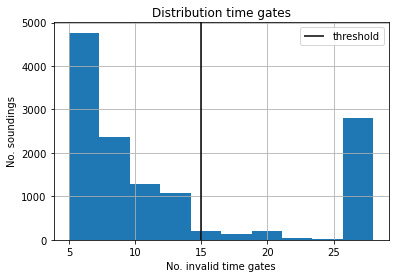

In [8]:
def utmrotate(x,y,x0=595855,y0=4059438,rotation=13.5,local=False):
    rotation = rotation*np.pi/180
    if local:
        orig_x,orig_y = (0,0)
    else:
        orig_x,orig_y = (x0,y0)
        
    x_rot = np.cos(rotation)*(x-x0) - np.sin(rotation)*(y-y0) + orig_x
    y_rot = np.sin(rotation)*(x-x0) + np.cos(rotation)*(y-y0) + orig_y
    return x_rot,y_rot  

#xll,yll for local grid
xmll,ymll = m_empty.modelgrid.xvertices[-1,0],m_empty.modelgrid.yvertices[-1,0]
xmll_rot,ymll_rot = utmrotate(xmll,ymll,x0=xll,y0=yll)

def global_to_local(x_glob,y_glob,rotx0=xll,roty0=yll,x0_local=xmll_rot,y0_local=ymll_rot):
    x_temp,y_temp = utmrotate(x_glob,y_glob,local=False,x0=rotx0,y0=roty0)
    x_temp -= x0_local
    y_temp -= y0_local
    return np.stack((x_temp,y_temp),axis=1)

#### Get timegates within boundary

In [9]:
#Remove values outside of the AEM_box

from shapely.geometry import Point, Polygon
iskip = 6
coords = [(m_empty.modelgrid.xvertices[0,0], m_empty.modelgrid.yvertices[0,0]),
          (m_empty.modelgrid.xvertices[-1,0], m_empty.modelgrid.yvertices[-1,0]),
          (m_empty.modelgrid.xvertices[-1,-1], m_empty.modelgrid.yvertices[-1,-1]),
          (m_empty.modelgrid.xvertices[0,-1], m_empty.modelgrid.yvertices[0,-1])
         ]
model_poly = Polygon(coords)
msk_AEM = np.zeros(len(df),dtype=np.bool)
for i,(x,y) in enumerate(zip(df.UTMX.values,df.UTMY.values)):
    msk_AEM[i]=Point(x,y).within(model_poly)
msk = np.logical_and(df.CHANNEL_NO==1, msk_AEM)
data_hm_all = df.loc[msk[msk].index+1,ch2_cols][::iskip]
data_lm_all = df.loc[msk[msk].index,ch1_cols][::iskip]



# #plot
# plt.scatter(df.UTMX[msk[msk].index],df.UTMY[msk[msk].index],s=10)
# plt.scatter(df.UTMX[msk[msk].index+1],df.UTMY[msk[msk].index+1],s=2)

In [10]:
from shapely.geometry import Point, Polygon


## Get the AEM data within boundary
iskip = 6
coords = [(m_empty.modelgrid.xvertices[0,0], m_empty.modelgrid.yvertices[0,0]),
          (m_empty.modelgrid.xvertices[-1,0], m_empty.modelgrid.yvertices[-1,0]),
          (m_empty.modelgrid.xvertices[-1,-1], m_empty.modelgrid.yvertices[-1,-1]),
          (m_empty.modelgrid.xvertices[0,-1], m_empty.modelgrid.yvertices[0,-1])
         ]
model_poly = Polygon(coords)
msk_AEM = np.zeros(len(df),dtype=np.bool)
for i,(x,y) in enumerate(zip(df.UTMX.values,df.UTMY.values)):
    msk_AEM[i]=Point(x,y).within(model_poly)
msk = np.logical_and(df.CHANNEL_NO==1, msk_AEM)
data_hm_all = df.loc[msk[msk].index+1,ch2_cols][::iskip]
data_lm_all = df.loc[msk[msk].index,ch1_cols][::iskip]





#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
# msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
x_m_rot,y_m_rot = utmrotate(m_empty.modelgrid.xvertices.flatten(),m_empty.modelgrid.yvertices.flatten(),local=False)

xy_global = df.loc[msk,['UTMX', 'UTMY']].values[::iskip]
xy = global_to_local(xy_global[:,0],xy_global[:,1])

Line = df.loc[msk,['LINE_NO']].values[::iskip]
dem = df.loc[msk,'ELEVATION'].values[::iskip]
height = df.loc[msk,'INVALT'].values[::iskip]
# height = df.loc[msk,'TX_ALTITUDE'].values[:]
system = df.loc[msk,'skytem_type'].values[::iskip]
msk_312 = system==312
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
n_sounding= xy.shape[0]

dx,dy,dz = (m_empty.dis.delr.array[0],
            m_empty.dis.delc.array[0],
            m_empty.dis.botm[-1] - m_empty.dis.botm[-2])


print ( 'msk',msk.shape,'\n'
'xy',xy.shape,'\n'
'Line',Line.shape,'\n'
'dem',dem.shape,'\n'
'height',height.shape,'\n'
'system',system.shape,'\n'
'rx_locations',rx_locations.shape,'\n'
'src_locations',src_locations.shape,'\n'
'topo',topo.shape,'\n')
#nodenumber in grid corresponding to AEM locations
# nodenumber_AEM = g.intersect(list(xy_global),'point',0).nodenumber

msk (8504,) 
xy (83, 2) 
Line (83, 1) 
dem (83,) 
height (83,) 
system (83,) 
rx_locations (83, 3) 
src_locations (83, 3) 
topo (83, 3) 



#### Make layer_mapping_ind

### Make mesh

In [11]:
nlay,nrow,ncol = (m_empty.nlay,
                  m_empty.nrow,
                  m_empty.ncol)
dx,dy,dz = (m_empty.dis.delr.array[0],
            m_empty.dis.delc.array[0],
             (m_empty.dis.botm[-2]-m_empty.dis.botm[-1]).mean())
Lx,Ly,Lz = (dx*ncol,
            dy*nrow,
            dz*nlay)


n_pad_ocean = 0
n_pad_inland = 100
n_pad_row = 10

hx = np.ones(ncol+n_pad_ocean+n_pad_inland) * dx
hy = np.ones(m_nm.nrow) * dy

hz = np.ones(71)*dz

# x0 = (-n_pad_inland*dx +x_m_rot.min(),-n_pad_row*dy + y_m_rot.min(),-386.21)
x0 = (-n_pad_ocean*dx,-n_pad_row*dy,-386.21)

mesh_large = Mesh.TensorMesh([hx, hy, hz],x0=x0)


hx = np.ones(ncol+n_pad_ocean+n_pad_inland) * dx
hy = np.ones(nrow + 2*n_pad_row) * dy
hz = np.ones(71)*dz

mesh = Mesh.TensorMesh([hx, hy, hz],x0=x0)



#### Find active indices

#### Get indices for inserted MODFLOW grids

##### 1) Merge MODFLOW grid and LF grid

##### 2) Insert into mesh

##### 3) Add above-ground resistivity values

#### Find ocean line

In [12]:
def find_ocean(m,layer_mapping_ind,ocean_elev=0):
    ocean_line = []

    for lay in range(m.dis.nlay):
        for row in range(m.dis.nrow):
            thislay = (lay,row,np.where(layer_mapping_ind[lay,row,:]!=0)[0][0])
            ocean_line.append(thislay)
            if lay==m.dis.nlay-1:
                pass
            else:
                nextlay = (lay+1,row,np.where(layer_mapping_ind[lay+1,row,:]!=0)[0][0])
                for col in np.arange(thislay[2],nextlay[2],-1):
                    ocean_line.append((lay,row,col))
    ocean_line = np.array(ocean_line).T


    ocean_grid = np.zeros((m.nlay,m.nrow,m.ncol),dtype=np.bool)
    ocean_grid[tuple(ocean_line)]=True
    ocean_grid[m.modelgrid.zvertices[1:,:,:]>ocean_elev]=False
    return ocean_line,ocean_grid

ocean_line,ocean_grid = find_ocean(m_nm,layer_mapping_ind_full)



### Get actv

In [14]:
from SimPEG.Utils import plot2Ddata, surface2ind_topo
x_nm,y_nm = utmrotate(m_nm.modelgrid.xcellcenters.flatten(),
                              m_nm.modelgrid.ycellcenters.flatten(),
                             x0=xll,y0=yll)
x_nm -= xmll_rot
y_nm-= ymll_rot

sealevel_X,sealevel_Y = np.meshgrid(mesh.vectorCCx,mesh.vectorCCy)
sealevel_xyz = np.stack((sealevel_X.flatten(),sealevel_Y.flatten(),np.zeros(sealevel_X.size)),axis=1)
topo_xyz =np.stack((x_nm.flatten(),
                    y_nm.flatten(),
                    topo_grid.flatten()),axis=1)

actv = surface2ind_topo(mesh,topo_xyz) #True if below ground surface 
isabove_sealevel = ~surface2ind_topo(mesh,sealevel_xyz) #True if below sea level


#### Output grid from SEAWAT

In [16]:
# kh_sand_180 = varlist['kh_sand_180'][it] #done
# kh_clay_180 = varlist['kh_clay_180'][it] #done
# kh_sand_400 = varlist['kh_sand_400'][it] #done
# kh_clay_400 = varlist['kh_clay_400'][it] #done
# kh_lay1     = varlist['kh_lay1'][it] #done 

RP_model = varlist['RP_model'][it]
m_ws = varlist['m'][it] #done
CF_cp = varlist['CF_cp'][it] #done
CF_cr = varlist['CF_cr'][it] #done
por = m.btn.prsity.array

lith_180 = np.load(lithdir.joinpath('snesim','mps180_{}.npy'.format(it))).astype(np.float)
lith_400 = np.load(lithdir.joinpath('sisim','sisim400_{}.npy'.format(it))).astype(np.float)


In [17]:
cf = np.zeros_like(layer_mapping_ind_full,dtype=np.float) #0=Clay, 1=Sand
cf[np.where(layer_mapping_ind_full==0)] = 1
cf[np.where(layer_mapping_ind_full==1)] = 1
cf[np.where(layer_mapping_ind_full==2)] = 0
cf[np.where(layer_mapping_ind_full==3)] = lith_180[np.where(layer_mapping_ind_full==3)] 
cf[np.where(layer_mapping_ind_full==4)] = 0
cf[np.where(layer_mapping_ind_full==5)] = lith_400[np.where(layer_mapping_ind_full==5)] 
cf[np.where(layer_mapping_ind_full>5)] = 1
cf[np.where(cf==0)] = CF_cr
cf[np.where(cf==1)] = CF_cp
cf = cf[:,rows,:]
conc[conc > 100.] = np.nan


In [19]:
if RP_model==0:
    #  WS -- HS+ transform
    sigma_bulk = RP_twostep(TDS=conc,CF=cf,por=por,m=m_ws)    
elif RP_model==1:
    #ML transform
    import lightgbm 
    gbm = lightgbm.Booster(model_file=datadir.joinpath('RockPhysics','gbm_production_model.mdl').as_posix())

    
    z_m = m_empty.modelgrid.zcellcenters
    top_elev = m_empty.modelgrid.zvertices[0,:,:]


    dept = (top_elev - z_m)/.3048
    dept_bin = (np.round(dept/10,0)*10).astype(np.int)

    aq_groupnum = np.zeros_like(layer_mapping_ind)
    aq_groupnum[np.where(np.isin(layer_mapping_ind,(1,2)))] = 1
    aq_groupnum[np.where(np.isin(layer_mapping_ind,(3,4)))] = 2
    aq_groupnum[np.where(layer_mapping_ind>=5)] = 3

    X = np.tile(m_empty.modelgrid.xcellcenters,(m_empty.nlay,1,1))
    Y = np.tile(m_empty.modelgrid.ycellcenters,(m_empty.nlay,1,1))
    TDS = conc/1000
    
    data = np.stack((TDS.flatten(),
                cf.flatten(),
                aq_groupnum.flatten(),
                dept_bin.flatten(),
                X.flatten(),
                Y.flatten()),axis=1)
    
    sigma_bulk = np.power(10,gbm.predict(data))
    sigma_bulk = sigma_bulk.reshape((m_empty.nlay,m_empty.nrow,m_empty.ncol))

#### AEM resistivity grid

In [20]:
aem_rho_tmp = np.load(datadir.joinpath('AEM','resistivity','AEM_Modflowsize.npy'),allow_pickle=True)
aem_msk = aem_rho_tmp =='OUT'
aem_rho = np.zeros_like(aem_rho_tmp,dtype='float')
aem_rho[~aem_msk] = aem_rho_tmp[~aem_msk]
aem_rho[aem_msk] = np.nan
aem_rho=aem_rho.reshape((52,m_nm.nrow,m_nm.ncol))[::-1,::-1,:]
aem_rho = np.power(10,aem_rho)

##### Merge grids

In [23]:
rho_background=10.
ind_bot_lay_0_lf = np.argmin(np.abs(mesh_large.vectorNz[::-1]- -2))
ind_bot_lay_19_lf = np.argmin(np.abs(mesh_large.vectorNz[::-1]- -148))

merged= aem_rho.copy()
merged[np.isnan(aem_rho)]=rho_background

#Insert modflow grid
merged[ind_bot_lay_0_lf:ind_bot_lay_19_lf,rows,:] = 1/sigma_bulk[1:,:,:]

#If any NaNs from modflow grid, overwrite them
RP_nan = np.where(np.isnan(sigma_bulk))
RP_nan = (RP_nan[0],RP_nan[1]+rows[0],RP_nan[2])
merged[RP_nan] = aem_rho[RP_nan]



#Set ocean resistivity 
for lay in range(ocean_grid.shape[0]):
    for row in range(ocean_grid.shape[1]):
        col = int(np.argwhere(ocean_grid[lay,row,:])[0])
        merged[ind_bot_lay_0_lf+lay-1,row,:col]=.2

merged = merged[::-1,:,:]

In [24]:
lf_insert = np.zeros(mesh_large.vnC,dtype=np.bool)
lf_insert[n_pad_ocean:mesh_large.vnC[0]-n_pad_inland,
               :,
               -aem_rho.shape[0]:] = True


In [25]:
rho_grid = np.ones(mesh_large.vnC) * rho_background
rho_grid[lf_insert] = np.transpose(merged,(2,1,0)).flatten(order='C')

rho_grid = rho_grid[:,np.arange(rows[0]-n_pad_row,rows[-1]+n_pad_row + 1),:]

rho_grid[~(actv.reshape(mesh.vnC,order='F'))] = np.nan
# rho_grid[np.where(np.logical_and(actv.reshape(mesh.vnC,order='F'),np.isnan(rho_grid)))

rho_grid[np.logical_and(actv.reshape(mesh.vnC,order='F'),np.isnan(rho_grid))]=rho_background

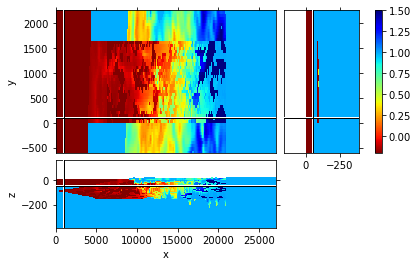

In [26]:
rho_grid = np.ones(mesh_large.vnC) * rho_background
rho_grid[lf_insert] = np.transpose(merged,(2,1,0)).flatten(order='C')

rho_grid = rho_grid[:,np.arange(rows[0]-n_pad_row,rows[-1]+n_pad_row + 1),:]

rho_grid[~(actv.reshape(mesh.vnC,order='F'))] = np.nan
rho_grid[np.logical_and(actv.reshape(mesh.vnC,order='F'),np.isnan(rho_grid))]=rho_background
rho_grid = rho_grid.flatten(order='F')
mesh.plot_3d_slicer(np.log10(rho_grid),xslice=1000,yslice=100,zslice=-50,pcolorOpts={'vmin':-.2,'vmax':1.5,'cmap':'jet_r'})

# mesh.plot_3d_slicer(actv,xslice=10000,yslice=100,zslice=-50)


### Leapfrog AEM discretization:

52 lay
300 row
345 col

top of model = 159.36849121 <br>
shared with SimPEG top of mesh <br>
rows and lays need to be reversed to line up with modflow model

### Set up survey

In [27]:
waveform_dir = datadir.joinpath('AEM','aem_waveform_marina')


### 304 Waveform ###
area_304 = 337.04
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

i_end_hm = -1
i_end_lm = -2

sl_hm_304 = slice(i_start_hm,i_end_hm)
sl_lm_304 = slice(i_start_lm,i_end_lm)

waveform_hm_304 = np.loadtxt(waveform_dir.joinpath('hm_304.txt'))
waveform_lm_304 = np.loadtxt(waveform_dir.joinpath('lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(waveform_dir.joinpath('time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
# times_LM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304
times_LM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_lm_304] - t0_lm_304

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
# times_HM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    
times_HM_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[sl_hm_304] - t0_hm_304    

Text(0.5, 1.0, 'High moment')

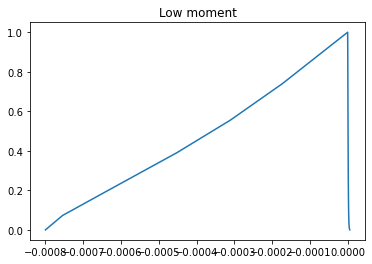

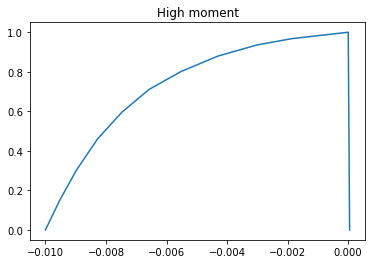

In [28]:
plt.plot(time_input_currents_LM_304, input_currents_LM_304,label='304')
plt.title('Low moment')
plt.figure()
plt.plot(time_input_currents_HM_304, input_currents_HM_304,label='304')
plt.title('High moment')

In [29]:
survey = get_skytem_survey(
    topo,
    src_locations,
    rx_locations,
    times_HM_304,
    time_input_currents_HM_304,
    input_currents_HM_304,
    base_frequency=25.,
    src_type="VMD",
    rx_type="dBzdt",    
    moment_type="dual",        
    time_dual_moment=times_LM_304,
    time_input_currents_dual_moment=time_input_currents_LM_304,
    input_currents_dual_moment=input_currents_LM_304,
    base_frequency_dual_moment=210.,
    wave_type="general",    
    field_type="secondary",    
)

>> Set parameters


### Create model

#### Create simulation

In [30]:
import shutil

aemdir = outputdir.joinpath('AEM')
if not aemdir.exists():
    aemdir.mkdir()

simulation_workdir = aemdir.joinpath('{modelname}_{it}_temp'.format(it=it,modelname=modelname),'_')

try:
    shutil.rmtree(simulation_workdir)
except:
    pass

try:
    simulation_workdir.mkdir()
except:
    pass

try:
    survey.unpair()
except:
    pass



simulation = GlobalSkyTEM(
    mesh, 
    sigma=1./rho_grid, 
    actv=actv, 
    parallel_option='multiprocess',
    n_cpu=2,
    work_dir=simulation_workdir.as_posix()
)
simulation.pair(survey)


In [31]:
%%time
print('writing inputs...\n')
simulation.write_inputs_on_disk_pool()
print('running simulation...\n')
dpred = simulation.forward(1./rho_grid)
print('finished simulation!')
np.save(aemdir.joinpath('{modelname}_{it}_{job_id}.npy'.format(it=it,modelname=modelname,job_id=job_id)),dpred)

writing inputs...

running simulation...

finished simulation!
CPU times: user 385 ms, sys: 617 ms, total: 1 s
Wall time: 1min 38s


### Compare simulated to observed data

In [35]:
sl_hm_304 = slice(i_start_hm,i_end_hm)
sl_lm_304 = slice(i_start_lm,i_end_lm)
lm_header_304 = ch1_cols[sl_lm_304]
hm_header_304 = ch2_cols[sl_hm_304]


floor_hm = 0.
floor_lm = 0.
std = 0.05

data = []
uncert = []
for idx in data_lm_all.index:
    if idx%1000==0:
        print(idx)
    data.append(np.r_[data_hm_all.loc[idx+1,hm_header_304].values/area_304,
                      data_lm_all.loc[idx,lm_header_304].values/area_304])
    uncert.append(np.r_[abs(data_hm_all.loc[idx+1,hm_header_304].values)/area_304*std + floor_hm,
                        abs(data_lm_all.loc[idx,lm_header_304].values)/area_304*std + floor_lm])
    
dobs = np.concatenate(data).ravel().astype('float')
uncert = np.concatenate(uncert).ravel().astype('float')
dobs[np.isnan(dobs)] = 9999./area_304
inactive_inds = dobs==9999./area_304
survey.dobs = -dobs.copy() 
uncert[inactive_inds] = np.Inf

In [36]:
DOBS = np.array(data).T
UNCERT  = np.array(uncert).T
invalid_inds = np.logical_or(DOBS==9999./area_304,DOBS==9999.)
DOBS[invalid_inds]=np.nan
DOBS_HM = DOBS[:times_HM_304.size,:]
DOBS_LM = DOBS[times_HM_304.size:,:]


In [37]:
DATA = dpred.reshape((times_HM_304.size+times_LM_304.size, n_sounding), order='F')
DATA[invalid_inds]=np.nan
DATA_HM = -DATA[:times_HM_304.size,:]
DATA_LM = -DATA[times_HM_304.size:,:]


Text(0.5, 1.0, 'Fractional mismatch (simulated-observed)/observed')

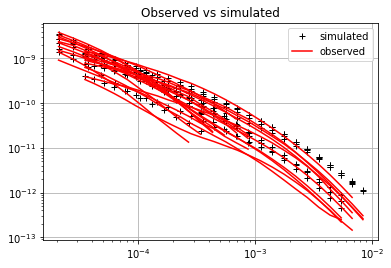

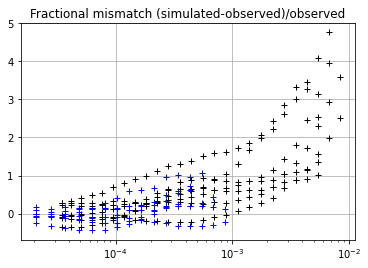

In [39]:
f,ax = plt.subplots(1)

n_lines = 10

l1 = plt.loglog(times_HM_304,DATA_HM[:,:n_lines],'k+',label='simulated')
plt.loglog(times_LM_304,DATA_LM[:,:n_lines],'k+')
l2 = plt.loglog(times_HM_304,DOBS_HM[:,:n_lines],'r',label='observed')
plt.loglog(times_LM_304,DOBS_LM[:,:n_lines],'r')
ax.grid(True)
plt.legend((ax.get_children()[0],ax.get_children()[n_lines*2]),
           (ax.get_children()[0].get_label(),ax.get_children()[n_lines*2].get_label()))
plt.title("Observed vs simulated")


f,ax = plt.subplots(1)
plt.semilogx(times_HM_304,((DATA_HM - DOBS_HM)/DOBS_HM)[:,:n_lines],'k+',label='HM')
plt.semilogx(times_LM_304,((DATA_LM - DOBS_LM)/DOBS_LM)[:,:n_lines],'b+',label='LM')
ax.grid(True)

plt.title('Fractional mismatch (simulated-observed)/observed')

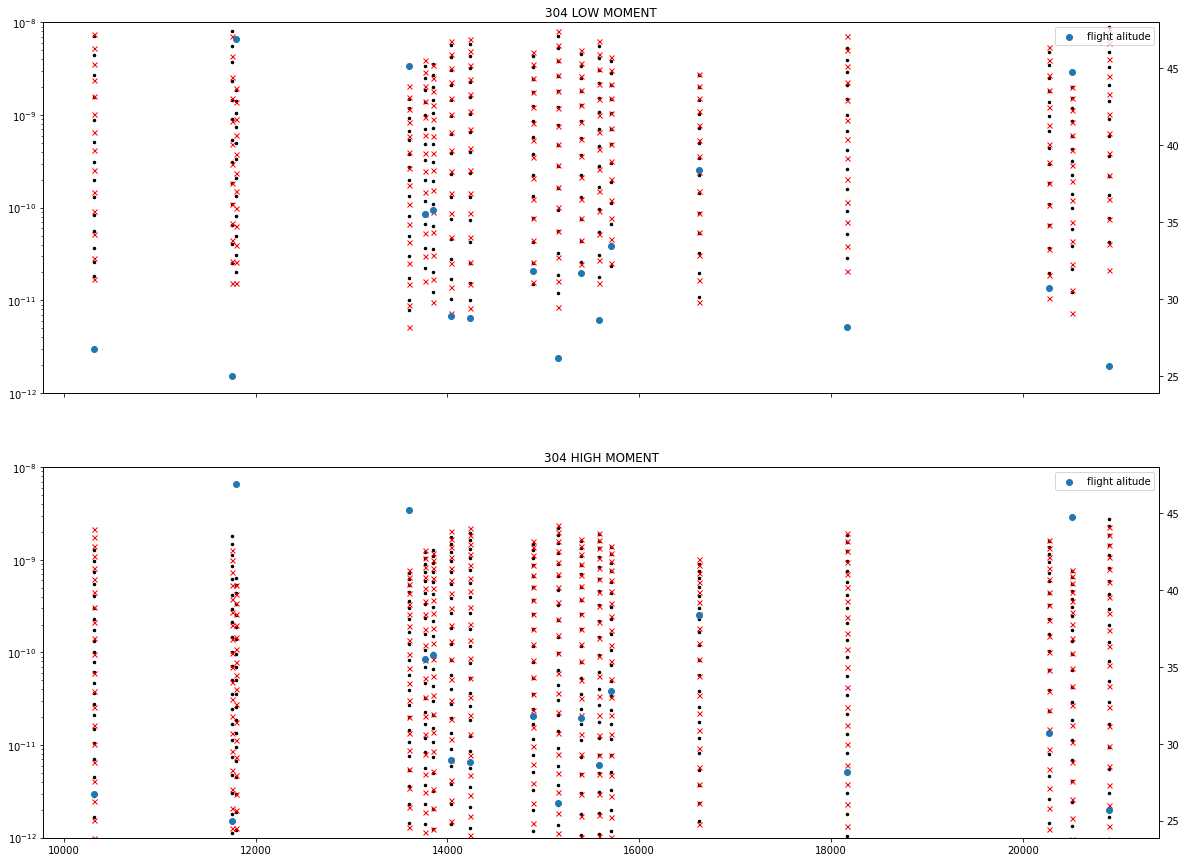

In [82]:
fig, axs = plt.subplots(2,1, figsize=(20, 15),sharex='col')

plt.sca(axs.flatten()[0])
ax = plt.gca()
out = plt.semilogy(xy[:,0], abs(DOBS_LM[:,:].T), 'k.', ms=5)
out = plt.semilogy(xy[:,0], abs(DATA_LM[:,:].T), 'rx', ms=5)
ax_1 = ax.twinx()
ax.set_ylim(1e-12, 1e-8)
ax_1.scatter(xy[:,0],height,label='flight alitude')
plt.title('304 LOW MOMENT')
plt.legend()

plt.sca(axs.flatten()[1])
ax = plt.gca()
out = plt.semilogy(xy[:,0], abs(DOBS_HM[:,:].T), 'k.', ms=5)
out = plt.semilogy(xy[:,0], abs(DATA_HM[:,:].T), 'rx', ms=5)
ax_1 = ax.twinx()
ax.set_ylim(1e-12, 1e-8)
ax_1.scatter(xy[:,0],height,label='flight alitude')
plt.title('304 HIGH MOMENT')
plt.legend()





